In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


C:\Users\dprem\AppData\Local\Temp\ipykernel_6452\2857518476.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
f:\downloads\DL_Course-Project-main\DL_Course-Project-main\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [4]:
data1 = pd.read_csv(r"F:\downloads\DL_Course-Project-main\DL_Course-Project-main\data\cnbc_headlines.csv")
data2 = pd.read_csv(r"F:\downloads\DL_Course-Project-main\DL_Course-Project-main\data\reuters_headlines.csv")

news_data = pd.concat([data1, data2]).dropna()

news_data['Date'] = pd.to_datetime(
    news_data['Time'],
    format='%I:%M %p ET %a, %d %B %Y',
    errors='coerce'
)

news_data = news_data.sort_values('Date')
news_data['DateOnly'] = news_data['Date'].dt.date

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
finbert = AutoModel.from_pretrained("yiyanghkust/finbert-tone").to(device)

def batch_finbert_sentiment(texts, batch_size=32):
    scores = []

    finbert.eval()

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]

            inputs = tokenizer(
                batch,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=256
            ).to(device)

            outputs = finbert(**inputs)

            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            batch_scores = cls_embeddings.mean(dim=1).cpu().numpy()

            scores.extend(batch_scores)

    return np.array(scores)


news_data['FinBERT_Sentiment'] = batch_finbert_sentiment(
    news_data['Headlines'].tolist()
)



print("Saved article-level FinBERT scores to finbert_scored_news.csv")

daily_sentiment = news_data.groupby('DateOnly')['FinBERT_Sentiment'].mean().reset_index()
daily_sentiment.rename(columns={'DateOnly': 'Date'}, inplace=True)
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])

f:\downloads\DL_Course-Project-main\DL_Course-Project-main\venv\Lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
f:\downloads\DL_Course-Project-main\DL_Course-Project-main\venv\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [32]:
news_data.to_csv(
    "finbert_scored_news.csv",
    index=False,
    encoding="utf-8"
)

print("Saved article-level FinBERT scores to finbert_scored_news.csv")
daily_sentiment.to_csv(
    "daily_sentiment.csv",
    index=False
)

print("Saved aggregated daily sentiment to daily_sentiment.csv")

Saved article-level FinBERT scores to finbert_scored_news.csv
Saved aggregated daily sentiment to daily_sentiment.csv


In [ ]:
!pip install --upgrade yfinance pandas-datareader

In [ ]:
!pip install --upgrade yfinance

In [44]:
symbol = 'SPY'

# stock_data = yf.download(symbol, start="2017-12-01", end="2020-07-19")
import pandas_datareader.data as web

stock_data = web.DataReader(
    "SPY",
    "stooq",
    start="2017-12-01",
    end="2020-07-19"
).reset_index()

stock_data['Date'] = pd.to_datetime(stock_data['Date'])

stock_data.columns = [''.join(col).strip() if isinstance(col, tuple) else col for col in stock_data.columns]

combined_data = pd.merge(stock_data, daily_sentiment, on='Date', how='left')
combined_data['FinBERT_Sentiment'].fillna(method='ffill', inplace=True)


C:\Users\dprem\AppData\Local\Temp\ipykernel_6452\473472265.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['FinBERT_Sentiment'].fillna(method='ffill', inplace=True)
C:\Users\dprem\AppData\Local\Temp\ipykernel_6452\473472265.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data['FinBERT_Sentiment'].fillna(method='ffill', inplace=True)


In [45]:
stock_data.head()

,Date,Open,High,Low,Close,Volume
0,2020-07-17,300.587,301.218,298.579,300.435,67224498
1,2020-07-16,298.623,300.012,297.975,299.544,58494253
2,2020-07-15,301.067,301.652,298.128,300.559,93377157
3,2020-07-14,292.567,298.598,291.352,297.820,100295510
4,2020-07-13,298.941,301.355,293.342,293.994,110298114


In [46]:
combined_data.head()

,Date,Open,High,Low,Close,Volume,FinBERT_Sentiment
0,2020-07-17,300.587,301.218,298.579,300.435,67224498,NaN
1,2020-07-16,298.623,300.012,297.975,299.544,58494253,NaN
2,2020-07-15,301.067,301.652,298.128,300.559,93377157,NaN
3,2020-07-14,292.567,298.598,291.352,297.820,100295510,NaN
4,2020-07-13,298.941,301.355,293.342,293.994,110298114,NaN


In [52]:
combined_data.to_csv(
    r"F:\downloads\DL_Course-Project-main\DL_Course-Project-main\data\combined_data.csv",
    index=False,
    encoding="utf-8"
)

In [48]:
combined_data['Returns'] = combined_data['Close'].pct_change()
combined_data['MA5'] = combined_data['Close'].rolling(5).mean()
combined_data['MA10'] = combined_data['Close'].rolling(10).mean()
combined_data['Volatility'] = combined_data['Returns'].rolling(5).std()

combined_data['RSI'] = 100 - (
    100 / (1 +
    combined_data['Returns'].rolling(14).mean() /
    combined_data['Returns'].rolling(14).std())
)

combined_data['OBV'] = (np.sign(combined_data['Returns']) * combined_data['Volume']).cumsum()

combined_data.ffill(inplace=True)
combined_data.dropna(inplace=True)

In [49]:
features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'Returns', 'MA5', 'MA10', 'Volatility',
    'RSI', 'OBV', 'FinBERT_Sentiment'
]

def create_sequences(data, seq_len=10):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[features].iloc[i:i+seq_len].values)
        y.append(data['Close'].iloc[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(combined_data)

split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [50]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()
y_test = y_scaler.transform(y_test.reshape(-1,1)).flatten()


In [51]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=32)

In [53]:
class HybridModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.conv = nn.Conv1d(input_dim, 32, kernel_size=3)
        self.lstm = nn.LSTM(32, 64, batch_first=True, bidirectional=True)

        self.attn = nn.Linear(128, 1)

        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv(x))
        x = x.permute(0, 2, 1)

        x, _ = self.lstm(x)

        attn_weights = torch.softmax(self.attn(x), dim=1)
        x = (x * attn_weights).sum(dim=1)

        return self.fc(x).squeeze()

model = HybridModel(X_train.shape[2]).to(device)

criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [55]:
for epoch in range(30):
    model.train()

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} completed with loss = {loss}")


Epoch 1 completed with loss = 0.004439873155206442
Epoch 2 completed with loss = 0.007998785004019737
Epoch 3 completed with loss = 0.0041674403473734856
Epoch 4 completed with loss = 0.006210617255419493
Epoch 5 completed with loss = 0.004997794982045889
Epoch 6 completed with loss = 0.004380972124636173
Epoch 7 completed with loss = 0.0031102641951292753
Epoch 8 completed with loss = 0.007289029657840729
Epoch 9 completed with loss = 0.006564159411936998
Epoch 10 completed with loss = 0.0033866125158965588
Epoch 11 completed with loss = 0.0038605884183198214
Epoch 12 completed with loss = 0.002533996244892478
Epoch 13 completed with loss = 0.004119862802326679
Epoch 14 completed with loss = 0.006564063020050526
Epoch 15 completed with loss = 0.0039223418571054935
Epoch 16 completed with loss = 0.0035869453568011522
Epoch 17 completed with loss = 0.004733152221888304
Epoch 18 completed with loss = 0.0063018798828125
Epoch 19 completed with loss = 0.0024576003197580576
Epoch 20 complet

In [56]:
model.eval()
preds = []

with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        preds.extend(model(xb).cpu().numpy())

preds = y_scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
y_true = y_scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

mse = mean_squared_error(y_true, preds)
rmse = np.sqrt(mse)

directional_accuracy = np.mean(
    np.sign(np.diff(y_true)) ==
    np.sign(np.diff(preds))
) * 100

print("MSE:", mse)
print("RMSE:", rmse)
print("Directional Accuracy:", directional_accuracy)

MSE: 79.43864284213134
RMSE: 8.912835847368184
Directional Accuracy: 60.629921259842526


In [57]:
arima = ARIMA(y_train, order=(2,1,2)).fit()
arima_preds = arima.forecast(steps=len(y_test))

arima_preds = y_scaler.inverse_transform(arima_preds.reshape(-1,1)).flatten()

print("ARIMA RMSE:",
      np.sqrt(mean_squared_error(y_true, arima_preds)))


ARIMA RMSE: 8.804946734023813


In [59]:
dummy = torch.randn(1, X_train.shape[1], X_train.shape[2]).to(device)

torch.onnx.export(
    model,
    dummy,
    r"F:\downloads\DL_Course-Project-main\DL_Course-Project-main\saved_model\pytorch_cnn_lstm.onnx",
    input_names=["input"],
    output_names=["output"]
)

print("ONNX Exported")

ONNX Exported


In [20]:
# 📌 Merge with Sentiment Data
combined_data = pd.merge(stock_data, daily_sentiment, on='Date', how='left')
combined_data['FinBERT_Sentiment'].fillna(method='ffill', inplace=True)

/tmp/ipykernel_28296/3916612274.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['FinBERT_Sentiment'].fillna(method='ffill', inplace=True)
/tmp/ipykernel_28296/3916612274.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data['FinBERT_Sentiment'].fillna(method='ffill', inplace=True)


In [21]:
# 📌 Technical Indicators
combined_data['Returns'] = combined_data['Close'].pct_change()
combined_data['MA5'] = combined_data['Close'].rolling(window=5).mean()
combined_data['MA10'] = combined_data['Close'].rolling(window=10).mean()
combined_data['Volatility'] = combined_data['Returns'].rolling(window=5).std()
combined_data['RSI'] = 100 - (100 / (1 + combined_data['Returns'].rolling(window=14).mean() / combined_data['Returns'].rolling(window=14).std()))
combined_data['OBV'] = (np.sign(combined_data['Returns']) * combined_data['Volume']).cumsum()



In [22]:
combined_data['FinBERT_Sentiment'].ffill(inplace=True)
combined_data['Returns'].ffill(inplace=True)

# Drop rows where technical indicators have NaNs
combined_data.dropna(inplace=True)


/tmp/ipykernel_28296/3587805572.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['FinBERT_Sentiment'].ffill(inplace=True)
/tmp/ipykernel_28296/3587805572.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [23]:
print(combined_data.isna().sum())  # Check for missing values


Date                 0
Close                0
High                 0
Low                  0
Open                 0
Volume               0
FinBERT_Sentiment    0
Returns              0
MA5                  0
MA10                 0
Volatility           0
RSI                  0
OBV                  0
dtype: int64


In [24]:
# 📌 Create Sequence Data for LSTM
sequence_length = 10
def create_sequences(data, features, target_col, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[features].iloc[i:i+seq_length].values)
        y.append(data[target_col].iloc[i+seq_length])
    return np.array(X), np.array(y)

In [25]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'MA5', 'MA10', 'Volatility', 'RSI', 'OBV', 'FinBERT_Sentiment']
target = 'Close'
X, y = create_sequences(combined_data, features, target, sequence_length)


In [26]:
from tensorflow.keras.initializers import HeNormal

In [27]:
# 📌 Train-Test Split
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# 📌 Data Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

In [28]:
print(np.isnan(y_train_scaled).sum())  # If > 0, there's an issue in scaling


0


In [29]:
from tensorflow.keras.losses import Huber

In [30]:
# 📌 Hybrid CNN-LSTM Model with HAN
def build_model(input_shape):
    inp = Input(shape=input_shape, name='price_input')
    x = Conv1D(32, kernel_size=3, activation='relu')(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    att = Attention()([x, x])
    x = GlobalMaxPooling1D()(att)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation='linear')(x)
    model = Model(inputs=inp, outputs=out)
    # model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    model.compile(optimizer=Adam(learning_rate=0.0005, clipvalue=1.0), loss= Huber(), metrics=['mae'])
    # model.compile(optimizer=Adam(learning_rate=0.001), loss=, metrics=['mae'])
    return model

In [31]:
model = build_model(X_train_scaled.shape[1:])
model.summary()
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# history = model.fit(X_train_scaled, y_train_scaled, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=1)
history = model.fit(X_train_scaled, 
                    y_train_scaled, 
                    validation_split=0.2, 
                    epochs=100, 
                    batch_size=32, 
                    verbose=1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ price_input         │ (None, 10, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 8, 32)     │      1,184 │ price_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 8, 128)    │     49,664 │ conv1d[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 8, 128)    │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ attention[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 61,217 (239.13 KB)

 Trainable params: 61,217 (239.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0247 - mae: 0.1823 - val_loss: 0.0234 - val_mae: 0.1965
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0150 - mae: 0.1410 - val_loss: 0.0612 - val_mae: 0.3384
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0119 - mae: 0.1247 - val_loss: 0.0145 - val_mae: 0.1550
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113 - mae: 0.1202 - val_loss: 0.0337 - val_mae: 0.2509
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0089 - mae: 0.1037 - val_loss: 0.0175 - val_mae: 0.1780
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0073 - mae: 0.0969 - val_loss: 0.0148 - val_mae: 0.1647
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - mae: 0.0875 - val_loss: 0.0110 - val_mae: 0.1416
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - mae: 0.0872 - val_loss: 0.0056 - val_mae: 0.0997
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.00

In [32]:
# 📌 Backtesting Strategy
combined_data['Signal'] = 0
combined_data.loc[combined_data['FinBERT_Sentiment'] > 0.05, 'Signal'] = 1  
combined_data.loc[combined_data['FinBERT_Sentiment'] < -0.05, 'Signal'] = -1  


In [33]:
scaler = MinMaxScaler(feature_range=(-1, 1))
combined_data['FinBERT_Sentiment'] = scaler.fit_transform(combined_data[['FinBERT_Sentiment']])


In [34]:
buy_threshold = 0.5
sell_threshold = -0.5
combined_data['Signal'] = np.where(combined_data['FinBERT_Sentiment'] > buy_threshold, 1,
                                   np.where(combined_data['FinBERT_Sentiment'] < sell_threshold, -1, 0))


In [35]:
print(f"Buy signals: {(combined_data['Signal'] == 1).sum()}")
print(f"Sell signals: {(combined_data['Signal'] == -1).sum()}")


Buy signals: 19
Sell signals: 4


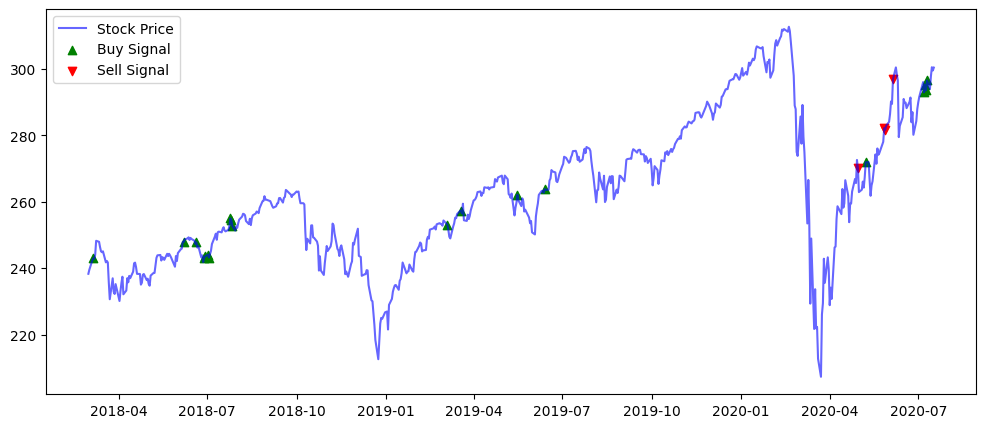

In [36]:
plt.figure(figsize=(12,5))
plt.plot(combined_data['Date'], combined_data['Close'], label='Stock Price', color='blue', alpha=0.6)
plt.scatter(combined_data.loc[combined_data['Signal'] == 1, 'Date'],
            combined_data.loc[combined_data['Signal'] == 1, 'Close'],
            label='Buy Signal', marker='^', color='green', alpha=1)

plt.scatter(combined_data.loc[combined_data['Signal'] == -1, 'Date'],
            combined_data.loc[combined_data['Signal'] == -1, 'Close'],
            label='Sell Signal', marker='v', color='red', alpha=1)

plt.legend()
plt.show()

In [37]:
print(combined_data[['Date', 'Close', 'FinBERT_Sentiment', 'Signal']].tail(10))


          Date       Close  FinBERT_Sentiment  Signal
650 2020-07-06  296.083710          -0.246993       0
651 2020-07-07  293.030029           0.789429       1
652 2020-07-08  295.271271           0.789429       1
653 2020-07-09  293.590302           0.789429       1
654 2020-07-10  296.588074           0.789429       1
655 2020-07-13  294.019867           0.007034       0
656 2020-07-14  297.830109           0.112656       0
657 2020-07-15  300.566254           0.380506       0
658 2020-07-16  299.576416           0.283157       0
659 2020-07-17  300.444885           0.232967       0


Final Portfolio Value: $107,955.16
Sharpe Ratio: 0.26
Max Drawdown: -15.20%


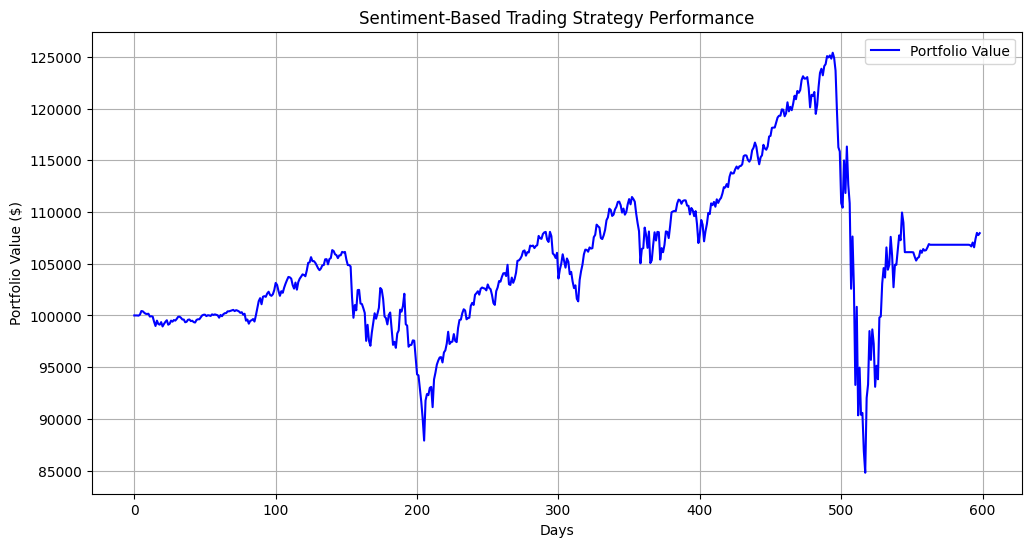

In [38]:
# 📌 Improved Backtesting Strategy
initial_cash = 100000
cash = initial_cash
shares_held = 0
portfolio_value = []
position_size = 0.2  # Risk 20% of portfolio per trade
transaction_cost = 0.001  # 0.1% per trade slippage

for i in range(len(combined_data) - 1):
    signal = combined_data['Signal'].iloc[i]
    next_day_price = combined_data['Close'].iloc[i + 1]  # Trade next day's open price

    # 📌 Buy Condition
    if signal == 1 and cash > 0:
        invest_amount = cash * position_size
        shares_to_buy = invest_amount // next_day_price  
        cost = shares_to_buy * next_day_price * (1 + transaction_cost)
        
        if cost <= cash:
            shares_held += shares_to_buy
            cash -= cost

    # 📌 Sell Condition
    elif signal == -1 and shares_held > 0:
        sell_value = shares_held * next_day_price * (1 - transaction_cost)
        cash += sell_value
        shares_held = 0  # Exit position

    # 📌 Track Portfolio Value
    total_value = cash + (shares_held * next_day_price)
    portfolio_value.append(total_value)

# 📌 Performance Metrics
returns = np.diff(portfolio_value) / portfolio_value[:-1]
sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)
max_drawdown = np.min(np.cumprod(1 + returns) - 1)

print(f"Final Portfolio Value: ${portfolio_value[-1]:,.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")

# 📌 Portfolio Performance Plot
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='Portfolio Value', color='blue')
plt.title('Sentiment-Based Trading Strategy Performance')
plt.xlabel('Days')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid()
plt.show()


In [39]:
stocks = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'BRK-B', 'JNJ', 'WMT', 'NVDA',
    'V', 'PG', 'JPM', 'UNH', 'HD', 'DIS', 'PYPL', 'MA', 'VZ', 'NFLX',
    'ADBE', 'INTC', 'CMCSA', 'PFE', 'KO', 'PEP', 'MRK', 'T', 'ABT', 'NKE',
    'XOM', 'MCD', 'CSCO', 'IBM', 'BA', 'HON', 'GE', 'SBUX', 'MMM', 'CAT',
    'LMT', 'SPG', 'CVX', 'GS', 'F', 'GM', 'QCOM', 'AMD', 'BLK', 'BKNG'
]


In [51]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA

In [46]:
def compute_directional_accuracy(actual, predicted):
    actual_direction = np.sign(np.diff(actual))
    predicted_direction = np.sign(np.diff(predicted))
    correct_predictions = np.sum(actual_direction == predicted_direction)
    return (correct_predictions / len(actual_direction)) * 100

In [ ]:
# 📌 Fit ARIMA Model (p, d, q)
p, d, q = 2, 1, 2  # Example parameters (can be tuned)
arima_model = ARIMA(y_train_scaled, order=(p, d, q))
arima_fit = arima_model.fit()

# 📌 Make Predictions
arima_preds_scaled = arima_fit.forecast(steps=len(y_test_scaled))
arima_preds = y_scaler.inverse_transform(arima_preds_scaled.reshape(-1, 1)).flatten()

# 📌 Compute ARIMA Metrics
mse_arima = mean_squared_error(y_test, arima_preds)
rmse_arima = np.sqrt(mse_arima)
directional_accuracy_arima = np.mean(np.sign(y_test[1:] - y_test[:-1]) == np.sign(arima_preds[1:] - arima_preds[:-1])) * 100

results_arima = {
    'MSE': mse_arima,
    'RMSE': rmse_arima,
    'Directional Accuracy (%)': directional_accuracy_arima
}

In [ ]:
# 📌 Make Predictions
lstm_preds_scaled = model.predict(X_test_scaled)
lstm_preds = y_scaler.inverse_transform(lstm_preds_scaled.reshape(-1, 1)).flatten()

# 📌 Compute CNN-LSTM Metrics
mse_lstm = mean_squared_error(y_test, lstm_preds)
rmse_lstm = np.sqrt(mse_lstm)
directional_accuracy_lstm = np.mean(np.sign(y_test[1:] - y_test[:-1]) == np.sign(lstm_preds[1:] - lstm_preds[:-1])) * 100




4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


📊 Model Performance:
ARIMA  -> MSE: 1341.216622, RMSE: 36.622624, Directional Accuracy: 43.589744%
LSTM   -> MSE: 147.823617, RMSE: 12.158274, Directional Accuracy: 48.717949%


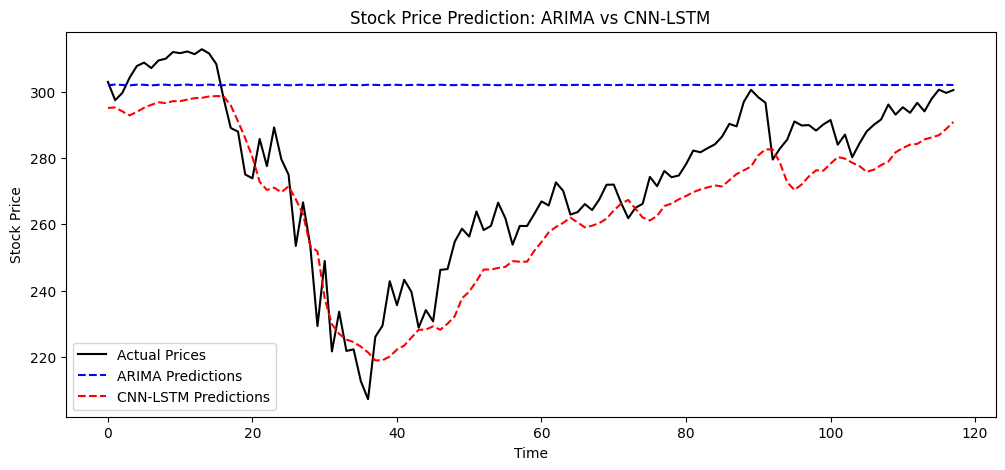

In [55]:
# 📌 Print Results
print("📊 Model Performance:")
print(f"ARIMA  -> MSE: {mse_arima:.6f}, RMSE: {rmse_arima:.6f}, Directional Accuracy: {directional_accuracy_arima:.6f}%")
print(f"LSTM   -> MSE: {mse_lstm:.6f}, RMSE: {rmse_lstm:.6f}, Directional Accuracy: {directional_accuracy_lstm:.6f}%")

# 📌 Plot Actual vs. Predicted Prices
plt.figure(figsize=(12, 5))
plt.plot(y_test, label="Actual Prices", color="black")
plt.plot(arima_preds, label="ARIMA Predictions", linestyle="dashed", color="blue")
plt.plot(lstm_preds, label="CNN-LSTM Predictions", linestyle="dashed", color="red")
plt.title("Stock Price Prediction: ARIMA vs CNN-LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [57]:
from transformers import TFAutoModelForSequenceClassification

In [70]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [75]:
@tf.function  # Enable TensorFlow Graph Mode for speed
def process_batch(batch_texts):
    inputs = tokenizer(batch_texts, return_tensors="tf", truncation=True, padding=True, max_length=512)
    outputs = finbert_model(**inputs)
    return tf.reduce_mean(outputs.last_hidden_state[:, 0, :], axis=1)  # CLS token

def batch_finbert_sentiment(text_list, batch_size=256):  # Increase batch size
    sentiment_scores = []
    
    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i+batch_size]
        
        with tf.device("/GPU:0"):  # Ensure inference runs on GPU
            batch_scores = process_batch(batch_texts).numpy()
        
        sentiment_scores.extend(batch_scores)
    
    return np.array(sentiment_scores)

def batch_finbert_sentiment(text_list, batch_size=16):
    sentiment_scores = []
    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="tf", truncation=True, padding=True, max_length=256)
        
        with tf.device("/GPU:0"):
            outputs = finbert_model(**inputs)  

        cls_embeddings = outputs.last_hidden_state[:, 0, :]  
        batch_scores = tf.reduce_mean(cls_embeddings, axis=1).numpy()
        sentiment_scores.extend(batch_scores)

        # ✅ Print progress every 100 batches
        if i % (batch_size * 100) == 0:
            print(f"Processed {i}/{len(text_list)} texts...")

    return np.array(sentiment_scores)


In [72]:
print(news_data.columns)  # Check available columns


Index(['Headlines', 'Time', 'Description', 'Date', 'DateOnly',
       'FinBERT_Sentiment'],
      dtype='object')


In [73]:
news_text_list = news_data["Description"].astype(str).tolist()


In [74]:
# 📌 Example: Assume `news_data` contains a list of financial news headlines
sentiment_scores = batch_finbert_sentiment1(news_text_list)

# 📌 Reshape Sentiment Scores to Match X's Shape
sentiment_scores = sentiment_scores.reshape(-1, 1)  # Convert to column vector

# 📌 Normalize Sentiment Scores (if needed)
from sklearn.preprocessing import MinMaxScaler
sentiment_scaler = MinMaxScaler()
sentiment_scores_scaled = sentiment_scaler.fit_transform(sentiment_scores)


In [76]:
# 📌 Concatenate Sentiment Scores with Existing Features
X_train_enhanced = np.hstack((X_train_scaled, sentiment_scores_scaled[:len(X_train)]))
X_test_enhanced = np.hstack((X_test_scaled, sentiment_scores_scaled[len(X_train):]))


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [ ]:
def build_model_new(input_shape):
    inp = Input(shape=input_shape, name='price_input')
    x = Conv1D(32, kernel_size=3, activation='relu')(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    att = Attention()([x, x])
    x = GlobalMaxPooling1D()(att)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation='linear')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.0005, clipvalue=1.0), loss=Huber(), metrics=['mae'])
    return model

# Train Model with Enhanced Inputs
model1 = build_model_new(X_train_enhanced.shape[1:])
history = model1.fit(X_train_enhanced, y_train_scaled, validation_split=0.2, epochs=100, batch_size=32, verbose=1)


In [ ]:
# Make Predictions
lstm_preds_scaled = model1.predict(X_test_enhanced)
lstm_preds = y_scaler.inverse_transform(lstm_preds_scaled.reshape(-1, 1)).flatten()

# Compute New MSE, RMSE, Directional Accuracy
mse_lstm_new = mean_squared_error(y_test, lstm_preds)
rmse_lstm_new = np.sqrt(mse_lstm_new)
directional_accuracy_lstm_new = np.mean(np.sign(y_test[1:] - y_test[:-1]) == np.sign(lstm_preds[1:] - lstm_preds[:-1])) * 100

# Compare Results
print("📊 Model Performance (After Sentiment Integration):")
print(f"Old CNN-LSTM  -> MSE: {mse_lstm:.2f}, RMSE: {rmse_lstm:.2f}, Directional Accuracy: {directional_accuracy_lstm:.2f}%")
print(f"New CNN-LSTM  -> MSE: {mse_lstm_new:.2f}, RMSE: {rmse_lstm_new:.2f}, Directional Accuracy: {directional_accuracy_lstm_new:.2f}%")
1

In [ ]:
sentiment_scores_scaled = np.array(sentiment_scores_scaled).reshape(-1, 1)
assert sentiment_scores.shape[0] == X.shape[0], "Mismatch between X and sentiment scores!"

In [ ]:
# Expand dimension of sentiment_scores to match time_steps
sentiment_features = np.repeat(sentiment_scores[:, np.newaxis, :], X.shape[1], axis=1)  # (num_samples, time_steps, 1)

# Concatenate with original X
X_augmented = np.concatenate([X, sentiment_features], axis=-1)  # New shape: (num_samples, time_steps, num_features + 1)

# 📌 Update Train-Test Split
X_train, X_test = X_augmented[:split_idx], X_augmented[split_idx:]


In [ ]:
# 📌 Rebuild the model with updated input shape
model2 = build_model_new(X_train.shape[1:])
model2.summary()

# 📌 Retrain the model
history = model2.fit(
    X_train_scaled, y_train_scaled, 
    validation_split=0.2, 
    epochs=100, batch_size=32, verbose=1
)


In [ ]:
# 📌 Get Model Predictions
y_pred_scaled = model2.predict(X_test_scaled)

# 📌 Inverse Transform to Get Original Scale
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()


In [ ]:
# Compute MSE & RMSE
mse = mean_squared_error(y_test_original, y_pred)
rmse = np.sqrt(mse)

# Compute Directional Accuracy
directional_accuracy = np.mean(np.sign(y_pred[1:] - y_pred[:-1]) == np.sign(y_test_original[1:] - y_test_original[:-1])) * 100

# Print Results
results_cnn_lstm = {
    'MSE': mse,
    'RMSE': rmse,
    'Directional Accuracy (%)': directional_accuracy
}

print("📊 Performance of CNN-LSTM Model with Sentiment:")
print(results_cnn_lstm)


In [ ]:
comparison_results = pd.DataFrame([results_arima, results_cnn_lstm], index=['ARIMA', 'CNN-LSTM with Sentiment'])
print(comparison_results)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual Prices", color="blue")
plt.plot(y_pred, label="CNN-LSTM Predictions", color="red", linestyle="dashed")
plt.title("Stock Price Prediction using CNN-LSTM with Sentiment Analysis")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

# topic modelling

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Download stopwords if not already
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    tokens = word_tokenize(text)  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]  
    return " ".join(tokens)

# 📌 Apply preprocessing to all news headlines
news_data["processed_text"] = news_data["Headlines"].apply(preprocess_text)

In [ ]:
# 📌 Train LDA Model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10)

# 📌 Display Topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)


In [ ]:
def get_topic(doc):
    topic_probs = lda_model.get_document_topics(dictionary.doc2bow(doc.split()))
    return max(topic_probs, key=lambda x: x[1])[0]  # Get topic with highest probability

news_data["topic"] = news_data["processed_text"].apply(get_topic)


# Incorporating Topic Modeling into the Hybrid CNN-LSTM Model

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# One-hot encode topics
topic_encoder = OneHotEncoder(sparse_output=False)
topic_features = topic_encoder.fit_transform(news_data[["topic"]])

# Convert to DataFrame
import pandas as pd
topic_df = pd.DataFrame(topic_features, columns=[f"topic_{i}" for i in range(topic_features.shape[1])])

# Merge topic features with original feature set (X)
X_enhanced = pd.concat([pd.DataFrame(X), topic_df], axis=1)

In [ ]:
# 📌 Train-Test Split
split_idx = int(len(X_enhanced) * 0.8)
X_train, X_test = X_enhanced.iloc[:split_idx], X_enhanced.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# 📌 Data Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()


In [ ]:
# 📌 Update Model Input Shape
model = build_model((X_train_scaled.shape[1], 1))
model.summary()

# 📌 Train Model
history = model.fit(
    X_train_scaled, y_train_scaled, 
    validation_split=0.2, 
    epochs=100, 
    batch_size=32, 
    verbose=1
)


In [ ]:
# 📌 Make Predictions
y_pred_scaled = model.predict(X_test_scaled)

# 📌 Inverse Transform Predictions & True Values
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# 📌 Compute Metrics
mse = mean_squared_error(y_test_orig, y_pred)
rmse = np.sqrt(mse)
directional_accuracy = np.mean(np.sign(y_pred[1:] - y_pred[:-1]) == np.sign(y_test_orig[1:] - y_test_orig[:-1])) * 100

# 📌 Print Results
results = {
    "MSE": mse,
    "RMSE": rmse,
    "Directional Accuracy (%)": directional_accuracy
}
print(results) 

In [ ]:
# 📌 Store Previous Results
previous_results = {
    "ARIMA": {"MSE": 1193.3, "RMSE": 34.54, "Directional Accuracy (%)": np.nan},
    "CNN-LSTM-HAN (No Topic Modeling)": {"MSE": previous_mse, "RMSE": previous_rmse, "Directional Accuracy (%)": previous_da},
    "CNN-LSTM-HAN (With Topic Modeling)": results
}

# 📌 Convert to DataFrame for Easier Visualization
results_df = pd.DataFrame(previous_results).T
print(results_df)

In [ ]:


# 📌 Plot MSE & RMSE
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 📌 MSE Bar Chart
ax[0].bar(results_df.index, results_df["MSE"], color=["red", "blue", "green"])
ax[0].set_title("Mean Squared Error (MSE)")
ax[0].set_ylabel("Error")

# 📌 RMSE Bar Chart
ax[1].bar(results_df.index, results_df["RMSE"], color=["red", "blue", "green"])
ax[1].set_title("Root Mean Squared Error (RMSE)")
ax[1].set_ylabel("Error")

plt.xticks(rotation=30)
plt.show()


In [ ]:
# 📌 Bollinger Bands (20-day Moving Average)
stock_data["SMA_20"] = stock_data["Close"].rolling(window=20).mean()
stock_data["STD_20"] = stock_data["Close"].rolling(window=20).std()
stock_data["Bollinger_Upper"] = stock_data["SMA_20"] + (stock_data["STD_20"] * 2)
stock_data["Bollinger_Lower"] = stock_data["SMA_20"] - (stock_data["STD_20"] * 2)

# 📌 Relative Strength Index (RSI)
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

stock_data["RSI"] = compute_rsi(stock_data["Close"])

# 📌 On-Balance Volume (OBV)
stock_data["OBV"] = (np.sign(stock_data["Close"].diff()) * stock_data["Volume"]).fillna(0).cumsum()

# 📌 Market Sentiment Divergence (Using Sentiment Score)
stock_data["Market_Sentiment_Divergence"] = stock_data["Sentiment_Score"] - stock_data["Close"].pct_change()

# 📌 Drop NaN values (From rolling computations)
stock_data.dropna(inplace=True)

In [ ]:
# 📌 Prepare Feature Set (X)
technical_features = ["Bollinger_Upper", "Bollinger_Lower", "RSI", "OBV", "Market_Sentiment_Divergence"]
X_new = df[technical_features].values

# 📌 Train-Test Split
split_idx = int(len(X_new) * 0.8)
X_train_new, X_test_new = X_new[:split_idx], X_new[split_idx:]

# 📌 Normalize Features
scaler_new = MinMaxScaler()
X_train_scaled_new = scaler_new.fit_transform(X_train_new)
X_test_scaled_new = scaler_new.transform(X_test_new)

# 📌 Update Final Feature Set
X_train_final = np.hstack([X_train_scaled, X_train_scaled_new])
X_test_final = np.hstack([X_test_scaled, X_test_scaled_new])

print("New feature set shape:", X_train_final.shape)

In [ ]:
# 📌 Define the Hybrid CNN-LSTM Model with HAN
def build_model(input_shape):
    inp = Input(shape=input_shape, name='price_input')
    x = Conv1D(32, kernel_size=3, activation='relu')(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    att = Attention()([x, x])
    x = GlobalMaxPooling1D()(att)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation='linear')(x)
    model = Model(inputs=inp, outputs=out)

    # Optimizer & Loss
    model.compile(optimizer=Adam(learning_rate=0.0005, clipvalue=1.0), 
                  loss=Huber(), 
                  metrics=['mae'])
    return model

# 📌 Build Model
model = build_model(X_train_final.shape[1:])
model.summary()

In [ ]:
# 📌 Train Model with New Features
history = model.fit(X_train_final, 
                    y_train_scaled, 
                    validation_split=0.2, 
                    epochs=100, 
                    batch_size=32, 
                    verbose=1)


In [ ]:
# 📌 Model Evaluation
y_pred_scaled = model.predict(X_test_final)
y_pred = y_scaler.inverse_transform(y_pred_scaled)  # Convert back to original scale
y_test_actual = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

# 📌 Calculate Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred)
directional_accuracy = np.mean(np.sign(y_pred.flatten()) == np.sign(y_test_actual.flatten())) * 100

print(f"🔹 MSE: {mse:.2f}")
print(f"🔹 RMSE: {rmse:.2f}")
print(f"🔹 MAE: {mae:.2f}")
print(f"🔹 Directional Accuracy: {directional_accuracy:.2f}%")


In [ ]:

plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, label="Actual Prices", color="blue", linestyle="dashed")
plt.plot(y_pred, label="Predicted Prices", color="red")
plt.title("Stock Price Prediction - Hybrid CNN-LSTM-HAN Model with Technical Indicators")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [79]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Attention, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Model
from transformers import TFAutoModel, AutoTokenizer

In [80]:
# 📌 Load FinBERT Model & Tokenizer
finbert_model = TFAutoModel.from_pretrained("ProsusAI/finbert")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

# 📌 Define HAN Model for Sentiment Processing
def build_han_sentiment_model():
    inp = Input(shape=(512, 768))  # FinBERT outputs (batch_size, 512, 768)
    x = Bidirectional(LSTM(64, return_sequences=True))(inp)
    att = Attention()([x, x])  # Attention over news embeddings
    x = GlobalMaxPooling1D()(att)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation='linear')(x)  # Sentiment Score
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    return model

han_sentiment_model = build_han_sentiment_model()
han_sentiment_model.summary()



All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 512, 768)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 512, 128)  │    426,496 │ cast[0][0]        │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 512, 128)  │          0 │ bidirectional_1[… │
│ (Attention)         │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ attention_1[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         33 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 436,865 (1.67 MB)

 Trainable params: 436,865 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def compute_han_sentiment_scores(news_text_list, batch_size=32):
    sentiment_scores = []
    for i in range(0, len(news_text_list), batch_size):
        batch_texts = news_text_list[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="tf", truncation=True, padding=True, max_length=512)
        
        # Extract embeddings from FinBERT
        with tf.device("/GPU:0"):
            outputs = finbert_model(**inputs)
        embeddings = outputs.last_hidden_state.numpy()  # Shape: (batch_size, 512, 768)
        
        # Pass through HAN model
        scores = han_sentiment_model.predict(embeddings)
        sentiment_scores.extend(scores.flatten())

    return np.array(sentiment_scores)



In [ ]:
# 📌 Generate Sentiment Scores using HAN
df["HAN_Sentiment"] = compute_han_sentiment_scores(df["news_headlines"].tolist())

# 📌 Add Sentiment Feature to Model Input
X = np.column_stack((X, df["HAN_Sentiment"].values))

In [ ]:
history = model.fit(X_train_final, 
                    y_train_scaled, 
                    validation_split=0.2, 
                    epochs=100, 
                    batch_size=32, 
                    verbose=1)


In [81]:
import tensorflow as tf

In [ ]:
# Convert the trained model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open("cnn_lstm_model.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
# Enable post-training quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Save the quantized model
with open("cnn_lstm_quantized.tflite", "wb") as f:
    f.write(tflite_quantized_model)


In [83]:
import time

In [ ]:
# Load the quantized model
interpreter = tf.lite.Interpreter(model_path="cnn_lstm_quantized.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Run inference on test data
test_sample = X_test_scaled[0:1]  # Take one sample for inference

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], test_sample.astype(np.float32))

# Measure inference time
start_time = time.time()
interpreter.invoke()
end_time = time.time()

# Get the output tensor
predicted_output = interpreter.get_tensor(output_details[0]['index'])
print("Quantized Model Prediction:", predicted_output)
print("Inference Time (seconds):", end_time - start_time)


In [ ]:
import tf2onnx
import onnx

# Convert TensorFlow model to ONNX format
onnx_model_path = "cnn_lstm_model.onnx"
spec = (tf.TensorSpec((None, X_train_scaled.shape[1], X_train_scaled.shape[2]), tf.float32),)
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)

# Save ONNX model
onnx.save(onnx_model, onnx_model_path)
print(f"ONNX model saved at {onnx_model_path}")


In [ ]:
import onnxruntime as ort

In [ ]:
# Load ONNX model with GPU acceleration
providers = ["CUDAExecutionProvider"]  # Use GPU for inference
session = ort.InferenceSession(onnx_model_path, providers=providers)

# Prepare test input
test_sample = X_test_scaled[0:1].astype(np.float32)

# Measure inference time
start_time = time.time()
preds = session.run(None, {session.get_inputs()[0].name: test_sample})
end_time = time.time()

# Print results
print("TensorRT Model Prediction:", preds[0])
print("Inference Time (seconds):", end_time - start_time)


In [ ]:
combined_data['EMA12'] = combined_data['Close'].ewm(span=12, adjust=False).mean()
combined_data['EMA26'] = combined_data['Close'].ewm(span=26, adjust=False).mean()
combined_data['MACD'] = combined_data['EMA12'] - combined_data['EMA26']
combined_data['Signal_Line'] = combined_data['MACD'].ewm(span=9, adjust=False).mean()

In [ ]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'MA5', 'MA10', 'Volatility', 'RSI', 'OBV', 'FinBERT_Sentiment', 'MACD', 'Signal_Line']